# Importaciones

In [1]:
!pip install -q evaluate transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import nltk, re, spacy
import torch, os, zipfile, chardet, umap

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet
from nltk import pos_tag
from evaluate import load
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

Usando: cuda


# Dataset cargado limpiado

In [3]:
# Descomprimir el archivo zip
def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data("bbc-train.zip", ".")
unzip_data("bbc-test.zip", ".")

In [4]:
# Cargar datos desde carpetas
def load_data(data_path):
    categories = ["business", "entertainment", "politics", "sports", "tech"]
    data = []

    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        return result['encoding']

    for category in categories:
        folder_path = os.path.join(data_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors="replace") as f:
                text = f.read()
                data.append((text, category))

    return pd.DataFrame(data, columns=["text", "category"])

# Cargar conjuntos de entrenamiento y test
df_train = load_data("bbc-train/")
df_test = load_data("bbc-test/")

# Preprocesamiento (Pipeline)

In [24]:
# Descargar recursos necesarios
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar modelo de spaCy para lematización
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 4e6

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
example = df_train["text"].iloc[0]

## 1. Tokenización

In [8]:
# 1. Tokenización
tokens = word_tokenize(example.lower())  # Convertir a minúsculas y tokenizar
tokens[:9]

['newest',
 'eu',
 'members',
 'underpin',
 'growth',
 'the',
 'european',
 'union',
 "'s"]

## 2. Estandarización

In [9]:
def standardize_tokens_spacy(tokens):
    text = " ".join(tokens)
    doc = nlp(text)

    standardized_tokens = [
        unicodedata.normalize("NFKD", token.text).encode("ASCII", "ignore").decode("utf-8")  # Eliminar acentos
        for token in doc
        if token.is_alpha
    ]

    return standardized_tokens

In [10]:
std_tokens = standardize_tokens_spacy(tokens)
print(std_tokens[:9])
print(f"Num tokens sin std: {len(tokens)}\nNum tokens con std: {len(std_tokens)}")

['newest', 'eu', 'members', 'underpin', 'growth', 'the', 'european', 'union', 'newest']
Num tokens sin std: 480
Num tokens con std: 390


# 3. Stop-words

In [11]:
stop_words = set(stopwords.words("english"))
stop_tokens = [token for token in std_tokens if token not in stop_words]
print(stop_tokens[:9])
print(f"Num tokens sin stop-words: {len(std_tokens)}\nNum tokens con stop-words: {len(stop_tokens)}")

['newest', 'eu', 'members', 'underpin', 'growth', 'european', 'union', 'newest', 'members']
Num tokens sin stop-words: 390
Num tokens con stop-words: 240


# 4. Stemming

In [12]:
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for token in stop_tokens]
stemmed_tokens[:9]

['newest',
 'eu',
 'member',
 'underpin',
 'growth',
 'european',
 'union',
 'newest',
 'member']

## 5. Lematización

In [13]:
lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(stemmed_tokens))]
lemmatized_tokens[:9]

['new',
 'eu',
 'member',
 'underpin',
 'growth',
 'european',
 'union',
 'new',
 'member']

## 6. Desambiguación

In [14]:
def get_wordnet_pos(word):
    """Mapea las etiquetas de POS de NLTK a las de WordNet."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
disambiguated_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in lemmatized_tokens]
disambiguated_tokens[:9]

['new',
 'eu',
 'member',
 'underpin',
 'growth',
 'european',
 'union',
 'new',
 'member']

## 7. Pipeline final

In [15]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = standardize_tokens_spacy(tokens)
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return tokens

In [16]:
df_train["processed"] = df_train["text"].apply(preprocess_text)
df_test["processed"] = df_test["text"].apply(preprocess_text)

In [17]:
print(df_train["processed"].iloc[0][:9])
df_train.head()

['new', 'eu', 'member', 'underpin', 'growth', 'european', 'union', 'new', 'member']


,text,category,processed
0,Newest EU members underpin growth\n\nThe Europ...,business,"[new, eu, member, underpin, growth, european, ..."
1,WorldCom bosses' $54m payout\n\nTen former dir...,business,"[worldcom, bos, payout, ten, former, director,..."
2,"US insurer Marsh cuts 2,500 jobs\n\nUp to 2,50...",business,"[u, insur, marsh, cut, job, job, go, u, insur,..."
3,US manufacturing expands\n\nUS industrial prod...,business,"[we, manufactur, expand, we, industri, product..."
4,Call to save manufacturing jobs\n\nThe Trades ...,business,"[call, save, manufactur, job, trade, union, co..."


In [18]:
print(df_test["processed"].iloc[0][:9])
df_test.head()

['sa', 'unveil', 'budget', 'south', 'african', 'govern', 'put', 'tax', 'cut']


,text,category,processed
0,SA unveils 'more for all' budget\n\nThe South ...,business,"[sa, unveil, budget, south, african, govern, p..."
1,BMW cash to fuel Mini production\n\nLess than ...,business,"[bmw, cash, fuel, mini, product, less, four, y..."
2,Deutsche Telekom sees mobile gain\n\nGerman te...,business,"[deutsch, telekom, see, mobil, gain, german, t..."
3,Japan economy slides to recession\n\nThe Japan...,business,"[japan, economi, slide, recess, japane, econom..."
4,Boeing unveils new 777 aircraft\n\nUS aircraft...,business,"[boe, unveil, new, aircraft, u, aircraft, firm..."


# Analisis

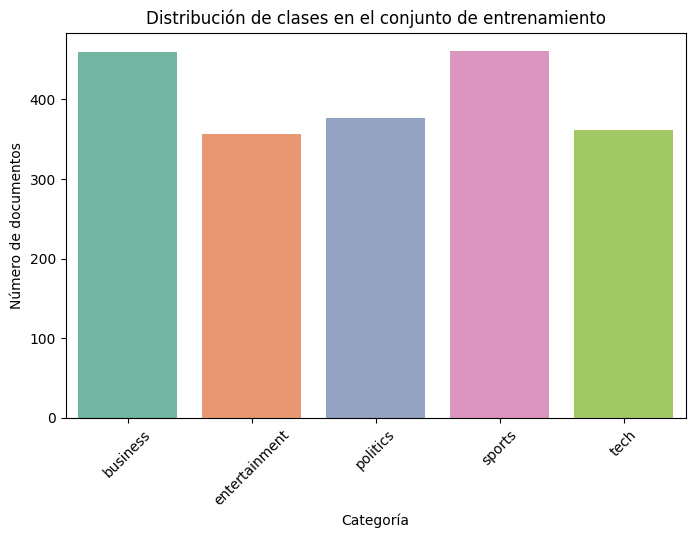

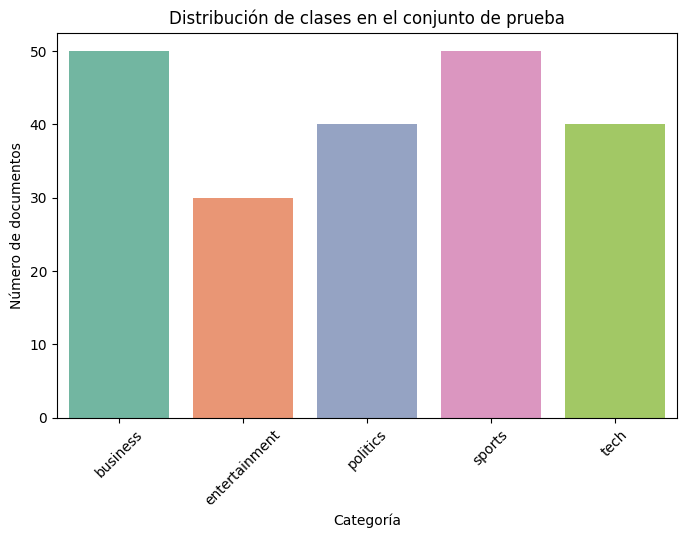

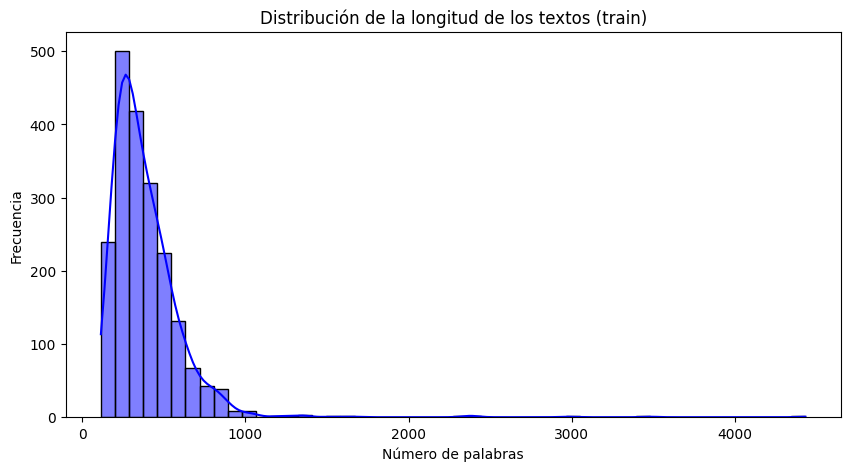

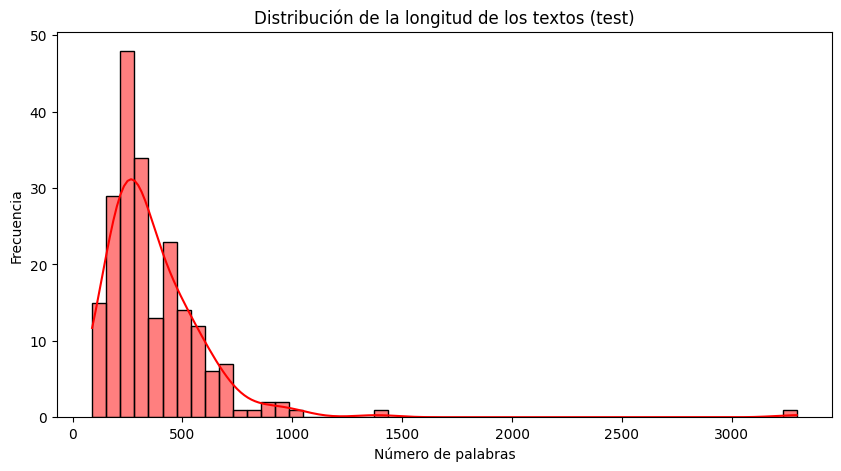

In [19]:
# Distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_train, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Distribución de clases en el conjunto de prueba
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_test, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Estadísticas básicas sobre la longitud de los textos
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribución de la longitud de los textos (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red")
plt.title("Distribución de la longitud de los textos (test)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## td-idf

In [20]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

df_train["processed_text"] = df_train["processed"].apply(lambda tokens: " ".join(tokens))
df_test["processed_text"] = df_test["processed"].apply(lambda tokens: " ".join(tokens))

X_train_tfidf = vectorizer.fit_transform(df_train["processed_text"])
X_test_tfidf = vectorizer.transform(df_test["processed_text"])

# Visualización de algunas palabras más relevantes por clase
feature_names = vectorizer.get_feature_names_out()
category_keywords = {}

for category in df_train["category"].unique():
    idx = df_train[df_train["category"] == category].index
    mean_tfidf = X_train_tfidf[idx].mean(axis=0)
    sorted_indices = mean_tfidf.argsort()[0, -10:].tolist()[0]
    category_keywords[category] = [feature_names[i] for i in sorted_indices]

keywords = {f"{category}": [] for category, _ in category_keywords.items()}
for category, words in category_keywords.items():
    keywords[category] = words

pd.DataFrame(keywords).T

,0,1,2,3,4,5,6,7,8,9
business,rise,price,economi,growth,year,market,firm,compani,bank,say
entertainment,nomin,oscar,year,band,good,say,music,star,award,film
politics,brown,minist,torus,govern,blair,parti,elect,labour,say,mr
sports,cup,club,team,match,say,player,win,england,play,game
tech,servic,user,comput,phone,peopl,technolog,mobil,say,use,game


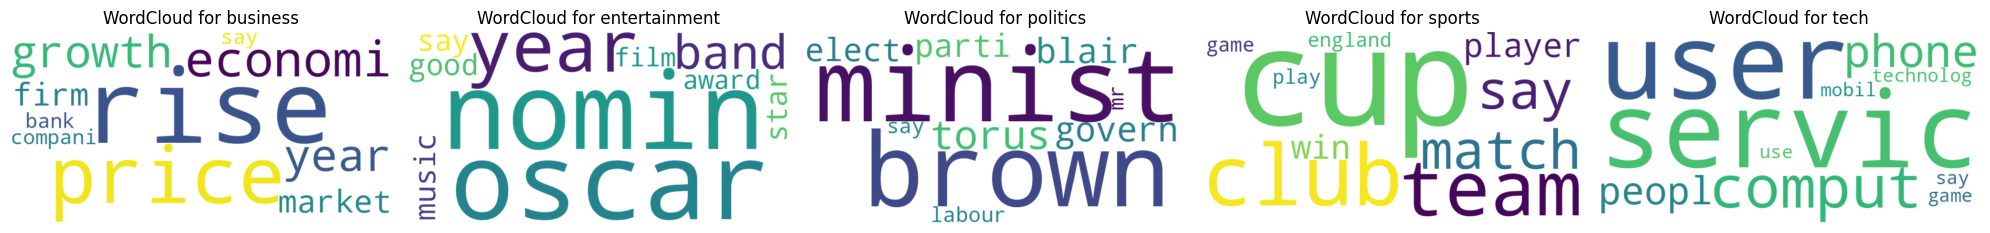

In [41]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for idx, (category, words) in enumerate(category_keywords.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    ax = axes[idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"WordCloud for {category}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Word Embeddings Word2Vec

In [25]:
sentences = df_train["processed"].apply(lambda x: ' '.join(x)).tolist()
doc = nlp(" ".join(sentences))  # Procesar todo el texto

# Ver los vectores de las palabras
word_vectors = {}
for token in doc:
    if not token.is_stop and not token.is_punct:  # Ignorar stopwords y puntuación
        word_vectors[token.text] = token.vector

# Para visualizar las palabras más similares a una palabra, por ejemplo "government":
target_word = "government"

# Verificar si la palabra está en el vocabulario de SpaCy
if target_word in word_vectors:
    target_vector = word_vectors[target_word]

    # Calcular la similitud coseno entre "government" y las demás palabras
    similarities = {}
    for word, vector in word_vectors.items():
        similarity = target_vector @ vector / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    # Obtener las top 10 palabras más similares
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_10_similar = sorted_similarities[:10]

    print("Palabras más similares a 'government':")
    for word, sim in top_10_similar:
        print(f"{word}: {sim:.4f}")
else:
    print(f"La palabra '{target_word}' no está en el vocabulario.")

Palabras más similares a 'government':
government: 1.0000
staff: 0.7584
sector: 0.7478
scamper: 0.7401
lili: 0.7280
emili: 0.7194
aesthet: 0.7150
lender: 0.7073
recognit: 0.7073
struggler: 0.7059


## Setence Embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


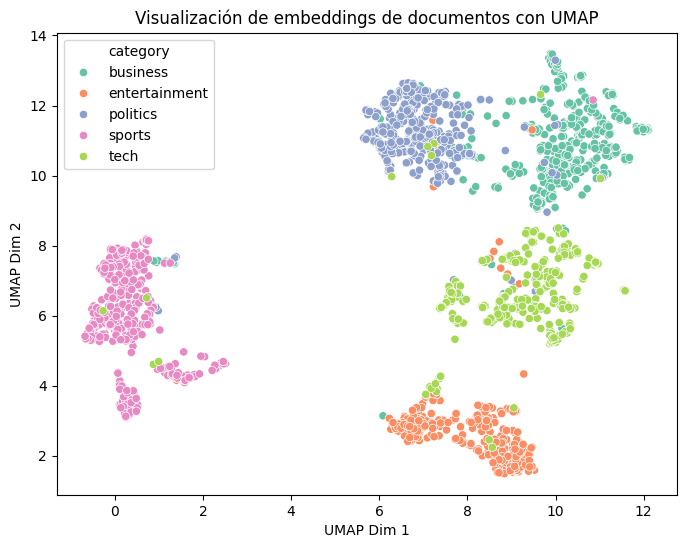

In [26]:
# Modelo de embeddings de oraciones
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generar embeddings
X_train_embeddings = model.encode(df_train["processed_text"])
X_test_embeddings = model.encode(df_test["processed_text"])

# Reducir dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
X_reduced = reducer.fit_transform(X_train_embeddings)

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_train["category"], palette="Set2")
plt.title("Visualización de embeddings de documentos con UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()

## LDA

In [27]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_tfidf)

# Mostrar las palabras más representativas de cada tema
for idx, topic in enumerate(lda.components_):
    print(f"Tema {df_train['category'].unique()[idx]}: {[feature_names[i] for i in topic.argsort()[-10:]]}")

Tema business: ['commodor', 'spam', 'worm', 'malici', 'mail', 'program', 'virus', 'infect', 'spywar', 'viru']
Tema entertainment: ['firm', 'compani', 'use', 'make', 'govern', 'new', 'peopl', 'year', 'mr', 'say']
Tema politics: ['spammer', 'umd', 'turkcel', 'ism', 'baa', 'simonetti', 'ballet', 'screensav', 'lyco', 'psp']
Tema sports: ['injuri', 'say', 'club', 'team', 'match', 'player', 'win', 'england', 'play', 'game']
Tema tech: ['band', 'festiv', 'yuko', 'actor', 'nomin', 'oscar', 'good', 'star', 'award', 'film']


# BERT (supervisado)

In [29]:
# --- Modelo Supervisado (Clasificación con BERT) ---

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(self.labels[idx])}

# Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = NewsDataset(df_train["processed_text"].tolist(), df_train["category"].astype('category').cat.codes.tolist(), tokenizer)
test_dataset = NewsDataset(df_test["processed_text"].tolist(), df_test["category"].astype('category').cat.codes.tolist(), tokenizer)

In [30]:
# Definir métricas
def compute_metrics(eval_pred):
    metric_accuracy = load("accuracy")
    metric_f1 = load("f1")
    metric_precision = load("precision")
    metric_recall = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "precision": metric_precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": metric_recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    }

In [31]:
# Modelo BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
training_args = TrainingArguments(output_dir="./results", num_train_epochs=5, per_device_train_batch_size=8, eval_strategy="epoch")
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cdf51342 (cdf51342-universidad-carlos-iii-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.174167
2,0.284900,0.104526
3,0.284900,0.033453
4,0.043000,0.033410
5,0.043000,0.034988


TrainOutput(global_step=1260, training_loss=0.1346075213144696, metrics={'train_runtime': 1125.2106, 'train_samples_per_second': 8.954, 'train_steps_per_second': 1.12, 'total_flos': 2650915285324800.0, 'train_loss': 0.1346075213144696, 'epoch': 5.0})

In [32]:
# Evaluación del modelo en test
results = trainer.evaluate()
print("Resultados en conjunto de test:", results)

Resultados en conjunto de test: {'eval_loss': 0.03498785197734833, 'eval_runtime': 6.5581, 'eval_samples_per_second': 32.022, 'eval_steps_per_second': 4.117, 'epoch': 5.0}


In [33]:
# Definir el directorio donde se guardará el modelo
output_dir = "./models/modelBERT"

# Guardar el modelo y el tokenizador
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modelo guardado en {output_dir}")

Modelo guardado en ./models/modelBERT


# LDA (no supervisado)

In [35]:
# --- Modelado de Temas (LDA) ---

# Crear el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Ajustar el modelo LDA a la matriz TF-IDF
lda.fit(X_train_tfidf)

# Obtener las palabras más relevantes de cada tema
feature_names = np.array(vectorizer.get_feature_names_out())
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[-10:][::-1]  # Top 10 palabras para cada tema
    top_words = feature_names[top_words_idx]
    print(" ".join(top_words))

Topic 1:
viru spywar infect virus program mail malici worm spam commodor
Topic 2:
say mr year peopl new govern make use compani firm
Topic 3:
psp lyco screensav ballet simonetti baa ism turkcel umd spammer
Topic 4:
game play england win player match team club say injuri
Topic 5:
film award star good oscar nomin actor yuko festiv band


# Almacenamiento de datos

In [ ]:
df_train.to_csv('data/results/training_dataset.csv')
df_test.to_csv('data/results/testing_dataset.csv')